# Proyecto NLP: Detección de Spam en SMS

## 1. Comprensión del Negocio (Business Understanding)

El objetivo de este proyecto es desarrollar modelos de Machine Learning y Deep Learning para clasificar mensajes SMS como spam o no spam (ham). Este problema es relevante para:
- Proteger a los usuarios de mensajes fraudulentos
- Mejorar la experiencia de usuario en aplicaciones de mensajería
- Reducir costos operativos en servicios de telecomunicaciones

**Criterios de éxito**: Lograr una precisión superior al 95% en la clasificación de mensajes spam.

In [7]:
!pip install openai tqdm pandas python-dotenv torch torchvision transformers scikit-learn pandas numpy matplotlib seaborn nltk

## 2. Comprensión de los Datos (Data Understanding)

### 2.1 Instalación de Dependencias

In [ ]:
import os
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
from dotenv import load_dotenv
from concurrent.futures import ThreadPoolExecutor, as_completed


# ==========================================
# 1 Cargar entorno y cliente
# ==========================================
env_loaded = load_dotenv()
print("dotenv loaded:", env_loaded)
print("Looking for .env in:", os.getcwd())

api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise RuntimeError("Falta la variable OPENAI_API_KEY en el entorno o archivo .env")
client = OpenAI(api_key=api_key)

# ==========================================
# 2 Cargar dataset
# ==========================================
df = pd.read_csv("sms-spam.csv", encoding="latin-1", header=0)
df = df.dropna(axis=1, how='all')  # eliminar columnas vacías
if df.shape[1] >= 2:
    df = df.iloc[:, :2].copy()
    df.columns = ['Target', 'Text']
else:
    raise ValueError("Formato inesperado del CSV: menos de 2 columnas no vacías")
df = df.dropna().reset_index(drop=True)
print("DataFrame shape:", df.shape)
df.head()

# ==========================================
# 3 Función de traducción segura
# ==========================================
def translate_text(text, retries=3):
    """Traduce texto al español corrigiendo errores de codificación."""
    for i in range(retries):
        try:
            response = client.chat.completions.create(
                model="gpt-4o-mini",
                messages=[
                    {
                        "role": "system",
                        "content": (
                            "Eres un traductor profesional al español. "
                            "Corrige automáticamente cualquier error de codificación (mojibake: Ã±, Â¡, Ã, …). "
                            "Restaura los caracteres originales y traduce manteniendo el tono exacto. "
                            "No agregues comentarios, explicaciones ni símbolos extra."
                        )
                    },
                    {
                        "role": "user",
                        "content": f"Traduce este texto al español corrigiendo la codificación:\n{text}"
                    }
                ],
                temperature=0,
            )
            return response.choices[0].message.content.strip()

        except Exception as e:
            print(f"⚠️ Error: {e}. Reintentando ({i+1}/{retries})...")
            time.sleep(2)

    return text


# ==========================================
# 4 Configuración general
# ==========================================
RUN_FULL_TRANSLATION = False # si ya esta traducido colocar false
CHECKPOINT_PATH = "spam_dataset_es_checkpoint.csv"
FINAL_PATH = "spam_dataset_es.csv"
MAX_WORKERS = 8                  # Número de hilos paralelos
SLEEP_BETWEEN_BATCHES = 2        # segundos entre grupos de hilos

# ==========================================
# 5 Cargar checkpoint (si existe)
# ==========================================
if os.path.exists(CHECKPOINT_PATH):
    print(f"🔄 Cargando checkpoint previo: {CHECKPOINT_PATH}")
    df_checkpoint = pd.read_csv(CHECKPOINT_PATH, encoding='latin-1')
    if 'Text_es' in df_checkpoint.columns:
        df['Text_es'] = df_checkpoint['Text_es']
    else:
        df['Text_es'] = pd.NA
else:
    df['Text_es'] = pd.NA

# Filas pendientes por traducir
pending_idx = df[df['Text_es'].isna()].index.tolist()
print(f"Total pendientes: {len(pending_idx)}")

# ==========================================
# 6Ejecución paralela
# ==========================================
if RUN_FULL_TRANSLATION:
    print(f"Iniciando traducción con {MAX_WORKERS} hilos paralelos...")
    batch_size = 100
    for start in range(0, len(pending_idx), batch_size):
        batch = pending_idx[start:start+batch_size]
        print(f"\nProcesando batch {start//batch_size + 1} ({len(batch)} filas)...")
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            future_to_idx = {
                executor.submit(translate_text, df.at[i, 'Text']): i for i in batch
            }
            for future in tqdm(as_completed(future_to_idx), total=len(batch)):
                idx = future_to_idx[future]
                try:
                    df.at[idx, 'Text_es'] = future.result()
                except Exception as e:
                    print(f"Error en fila {idx}: {e}")
                    df.at[idx, 'Text_es'] = df.at[idx, 'Text']

        # Guardar checkpoint
        df.to_csv(CHECKPOINT_PATH, index=False)
        print(f"Guardado checkpoint tras {start + len(batch)} filas ({CHECKPOINT_PATH})")
        time.sleep(SLEEP_BETWEEN_BATCHES)

    # Guardar resultado final
    df.to_csv(FINAL_PATH, index=False)
    print(f"Traducción completa. Guardado como {FINAL_PATH}")
else:
    print("RUN_FULL_TRANSLATION está en False. Traducción no ejecutada.")


dotenv loaded: True
Looking for .env in: /content
DataFrame shape: (5572, 2)
Total pendientes: 5572
RUN_FULL_TRANSLATION está en False. Traducción no ejecutada.


### 2.2 Traducción del Dataset al Español

El dataset original está en inglés. Usaremos OpenAI GPT-4o-mini para traducir los mensajes al español, manteniendo el tono y corrigiendo errores de codificación.

In [9]:
import pandas as pd
import unicodedata
import re
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 3. Preparación de los Datos (Data Preparation)

### 3.1 Importación de Bibliotecas

In [10]:
# ======================================================
# 2 Carga del dataset traducido
# ======================================================
df = pd.read_csv("spam_dataset_es.csv")

# usamos solo la etiqueta y el texto traducido
df = df[["Target", "Text_es"]].dropna().rename(columns={"Text_es": "Texto"})
df.head()

print("Tamaño del dataset:", df.shape)
print(df["Target"].value_counts())


Tamaño del dataset: (5572, 2)
Target
ham     4825
spam     747
Name: count, dtype: int64


### 3.2 Carga y Exploración del Dataset Traducido

In [ ]:
import re
import unicodedata
from nltk.tokenize import word_tokenize

spanish_stopwords = set(stopwords.words("spanish"))

def limpiar_texto(text):

    text = str(text)

    # 1 Corregir encoding
    text = text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore')

    # 2 Normalización unicode
    text = unicodedata.normalize("NFKC", text)

    # 3 Reemplazar URLs por <url>
    text = re.sub(r"http\S+|www\.\S+", " <url> ", text)

    # 4 Mantener letras, números y símbolos útiles
    text = re.sub(r"[^0-9a-zA-ZáéíóúÁÉÍÓÚñÑüÜ¿¡!?,.%$:/\-+\s]", "", text)

    # 5 Minúsculas
    text = text.lower()

    # 6 Tokenizar
    tokens = word_tokenize(text, language="spanish")

    # 7 OPCIONAL: quitar stopwords
    tokens = [t for t in tokens if t not in spanish_stopwords]

    # 8 Unir
    return " ".join(tokens)


### 3.3 Limpieza y Preprocesamiento de Texto

In [12]:
df["texto_limpio"] = df["Texto"].apply(limpiar_texto)
df.head(10)

,Target,Texto,texto_limpio
0,ham,"Ve hasta Jurong Point, loco... Disponible solo...","ve jurong point , loco ... disponible solo bug..."
1,ham,"Está bien, amigo... Solo bromeando contigo...","est bien , amigo ... solo bromeando contigo ..."
2,spam,Entrada gratuita en un concurso semanal para g...,entrada gratuita concurso semanal ganar entrad...
3,ham,"Tú no dices tan temprano, ¿eh? Tú ya puedes de...","t dices tan temprano , eh ? t puedes decirlo e..."
4,ham,"No, no creo que él vaya a USF, aunque vive por...",", creo l vaya usf , aunque vive aqu ."
5,spam,"FreeMsg Hola cariño, han pasado 3 semanas y no...","freemsg hola cario , pasado 3 semanas recibido..."
6,ham,Incluso mi hermano no quiere hablar conmigo. M...,incluso hermano quiere hablar conmigo . tratan...
7,ham,"Según tu solicitud, 'Melle Melle (Oru Minnamin...","segn solicitud , melle melle oru minnaminungin..."
8,spam,"¡GANADOR! Como cliente valioso de la red, ha s...","ganador ! cliente valioso red , sido seleccion..."
9,spam,¿Tienes tu móvil desde hace 11 meses o más? Ti...,mvil hace 11 meses ms ? derecho actualizar lti...


### 3.4 Aplicación de Limpieza al Dataset

In [13]:
# ======================================================
# 4 Vectorización con TF-IDF
# ======================================================
X = df["texto_limpio"]
y = df["Target"].map({"ham": 0, "spam": 1})

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, y, test_size=0.2, random_state=42, stratify=y
)

# Balanceo de clases (spam < ham)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


### 3.5 Vectorización y División de Datos

=== Resultados SVM ===
Accuracy: 0.9820627802690582
              precision    recall  f1-score   support

     No Spam       0.99      0.99      0.99       966
        Spam       0.93      0.94      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



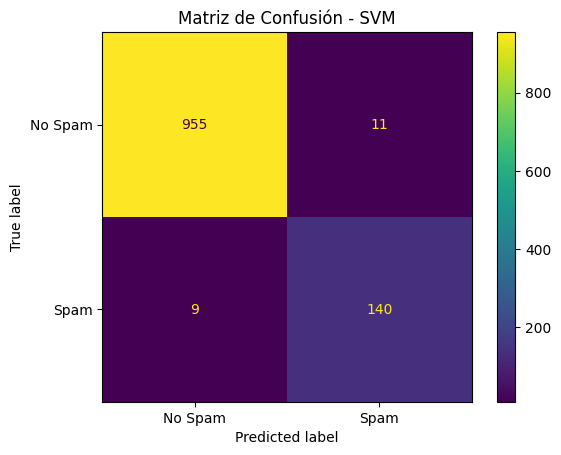

In [14]:
# ======================================================
# 5 Modelo baseline 1: SVM lineal
# ======================================================
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("=== Resultados SVM ===")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm, target_names=["No Spam", "Spam"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm, display_labels=["No Spam","Spam"])
plt.title("Matriz de Confusión - SVM")
plt.show()


## 4. Modelado (Modeling)

### 4.1 Modelo Baseline 1: SVM Lineal

=== Resultados FFNN ===
Accuracy: 0.9704035874439462
              precision    recall  f1-score   support

     No Spam       0.99      0.97      0.98       966
        Spam       0.84      0.96      0.90       149

    accuracy                           0.97      1115
   macro avg       0.92      0.97      0.94      1115
weighted avg       0.97      0.97      0.97      1115



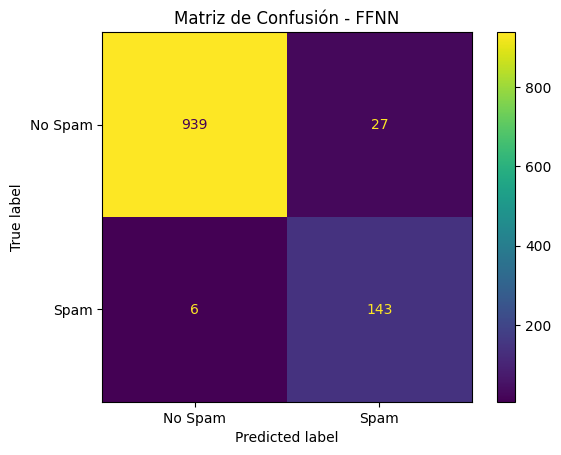

In [15]:
# ======================================================
# 6 Modelo baseline 2: Red neuronal simple (FFNN)
# ======================================================
mlp = MLPClassifier(hidden_layer_sizes=(128,), activation="relu", max_iter=20, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

print("=== Resultados FFNN ===")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp, target_names=["No Spam", "Spam"]))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_mlp, display_labels=["No Spam","Spam"])
plt.title("Matriz de Confusión - FFNN")
plt.show()


### 4.2 Modelo Baseline 2: Red Neuronal FFNN

In [16]:
# ======================================================
# 7 Conclusiones
# ======================================================
print("Resumen de desempeño:")
print(f"SVM Accuracy:  {accuracy_score(y_test, y_pred_svm):.3f}")
print(f"FFNN Accuracy: {accuracy_score(y_test, y_pred_mlp):.3f}")



Resumen de desempeño:
SVM Accuracy:  0.982
FFNN Accuracy: 0.970


### 4.3 Comparación de Modelos Baseline

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW # Corrected import to use torch.optim.AdamW
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuración
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

# Usar GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


### 4.4 Preparación para Modelos Avanzados

In [18]:
# Cargar dataset traducido
df = pd.read_csv('spam_dataset_es.csv')

# Seleccionar columnas relevantes y renombrar
df = df[['Target', 'Text_es']].dropna() # Asegurarse de mantener las dos columnas y eliminar filas con NaNs
df = df.rename(columns={'Target': 'label', 'Text_es': 'Texto'})

# Mapear la columna 'label' a binario
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Verificar estructura
print(f"Forma del dataset: {df.shape}")
print(f"\nPrimeras filas:")
print(df.head())

# Distribución de clases
print(f"\nDistribución de clases:")
print(df['label'].value_counts())
print(f"\nPorcentaje de spam: {df['label'].mean()*100:.2f}%")

Forma del dataset: (5572, 2)

Primeras filas:
   label                                              Texto
0      0  Ve hasta Jurong Point, loco... Disponible solo...
1      0      Está bien, amigo... Solo bromeando contigo...
2      1  Entrada gratuita en un concurso semanal para g...
3      0  Tú no dices tan temprano, ¿eh? Tú ya puedes de...
4      0  No, no creo que él vaya a USF, aunque vive por...

Distribución de clases:
label
0    4825
1     747
Name: count, dtype: int64

Porcentaje de spam: 13.41%


In [19]:
import re
import unicodedata
from nltk.tokenize import word_tokenize

spanish_stopwords = set(stopwords.words("spanish"))

def limpiar_texto(text):

    text = str(text)

    # 1 Corregir encoding
    text = text.encode('latin-1', errors='ignore').decode('utf-8', errors='ignore')

    # 2 Normalización unicode
    text = unicodedata.normalize("NFKC", text)

    # 3 Reemplazar URLs por <url>
    text = re.sub(r"http\S+|www\.\S+", " <url> ", text)

    # 4 Mantener letras, números y símbolos útiles
    text = re.sub(r"[^0-9a-zA-ZáéíóúÁÉÍÓÚñÑüÜ¿¡!?,.%$:/\-+\s]", "", text)

    # 5 Minúsculas
    text = text.lower()

    # 6 Tokenizar
    tokens = word_tokenize(text, language="spanish")

    # 7 OPCIONAL: quitar stopwords
    tokens = [t for t in tokens if t not in spanish_stopwords]

    # 8 Unir
    return " ".join(tokens)


In [20]:
df["texto_limpio"] = df["Texto"].apply(limpiar_texto)
df.head(10)

,label,Texto,texto_limpio
0,0,"Ve hasta Jurong Point, loco... Disponible solo...","ve jurong point , loco ... disponible solo bug..."
1,0,"Está bien, amigo... Solo bromeando contigo...","est bien , amigo ... solo bromeando contigo ..."
2,1,Entrada gratuita en un concurso semanal para g...,entrada gratuita concurso semanal ganar entrad...
3,0,"Tú no dices tan temprano, ¿eh? Tú ya puedes de...","t dices tan temprano , eh ? t puedes decirlo e..."
4,0,"No, no creo que él vaya a USF, aunque vive por...",", creo l vaya usf , aunque vive aqu ."
5,1,"FreeMsg Hola cariño, han pasado 3 semanas y no...","freemsg hola cario , pasado 3 semanas recibido..."
6,0,Incluso mi hermano no quiere hablar conmigo. M...,incluso hermano quiere hablar conmigo . tratan...
7,0,"Según tu solicitud, 'Melle Melle (Oru Minnamin...","segn solicitud , melle melle oru minnaminungin..."
8,1,"¡GANADOR! Como cliente valioso de la red, ha s...","ganador ! cliente valioso red , sido seleccion..."
9,1,¿Tienes tu móvil desde hace 11 meses o más? Ti...,mvil hace 11 meses ms ? derecho actualizar lti...


In [21]:
# División de datos
X = df['Texto'].values
y = df['label'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=RANDOM_STATE, stratify=y_temp
)

print(f"Datos de entrenamiento: {len(X_train)}")
print(f"Datos de validación: {len(X_val)}")
print(f"Datos de prueba: {len(X_test)}")

Datos de entrenamiento: 3900
Datos de validación: 836
Datos de prueba: 836


### 4.5 Modelo Avanzado #1: LSTM (Long Short-Term Memory)

#### Arquitectura:
- Embedding layer (vocabulario personalizado)
- 2 capas LSTM bidireccionales
- Dropout para regularización
- Capa densa de salida

#### Hiperparámetros Documentados:

In [22]:
# ==================== HIPERPARÁMETROS LSTM ====================
LSTM_CONFIG = {
    # Tokenización
    'vocab_size': 10000,        # Tamaño del vocabulario
    'max_length': 100,          # Longitud máxima de secuencia

    # Arquitectura
    'embedding_dim': 128,       # Dimensión de embeddings
    'hidden_dim': 256,          # Dimensión de capa oculta LSTM
    'num_layers': 2,            # Número de capas LSTM
    'bidirectional': True,      # LSTM bidireccional
    'dropout': 0.3,             # Dropout para regularización

    # Entrenamiento
    'batch_size': 64,           # Tamaño de batch
    'learning_rate': 0.001,     # Tasa de aprendizaje
    'epochs': 10,               # Número de épocas
    'weight_decay': 1e-5,       # L2 regularization
}

print("Configuración del modelo LSTM:")
for key, value in LSTM_CONFIG.items():
    print(f"  {key}: {value}")

Configuración del modelo LSTM:
  vocab_size: 10000
  max_length: 100
  embedding_dim: 128
  hidden_dim: 256
  num_layers: 2
  bidirectional: True
  dropout: 0.3
  batch_size: 64
  learning_rate: 0.001
  epochs: 10
  weight_decay: 1e-05


In [23]:
# Tokenización simple
from collections import Counter
import re

def tokenize(text):
    """Tokenización básica"""
    return re.findall(r'\b\w+\b', text.lower())

# Construir vocabulario
all_words = []
for text in X_train:
    all_words.extend(tokenize(text))

word_counts = Counter(all_words)
most_common = word_counts.most_common(LSTM_CONFIG['vocab_size'] - 2)  # -2 para PAD y UNK

# Crear diccionarios
word2idx = {'<PAD>': 0, '<UNK>': 1}
for idx, (word, _) in enumerate(most_common, start=2):
    word2idx[word] = idx

idx2word = {idx: word for word, idx in word2idx.items()}

print(f"Tamaño del vocabulario: {len(word2idx)}")
print(f"Palabras más comunes: {list(word2idx.keys())[2:12]}")

Tamaño del vocabulario: 7806
Palabras más comunes: ['de', 'que', 'a', 'en', 'no', 'y', 'la', 'el', 'un', 'para']


In [24]:
def text_to_sequence(text, word2idx, max_length):
    """Convierte texto a secuencia de índices"""
    tokens = tokenize(text)
    sequence = [word2idx.get(word, word2idx['<UNK>']) for word in tokens]

    # Padding o truncado
    if len(sequence) < max_length:
        sequence = sequence + [word2idx['<PAD>']] * (max_length - len(sequence))
    else:
        sequence = sequence[:max_length]

    return sequence

# Convertir datos
X_train_seq = np.array([text_to_sequence(text, word2idx, LSTM_CONFIG['max_length']) for text in X_train])
X_val_seq = np.array([text_to_sequence(text, word2idx, LSTM_CONFIG['max_length']) for text in X_val])
X_test_seq = np.array([text_to_sequence(text, word2idx, LSTM_CONFIG['max_length']) for text in X_test])

print(f"Forma de X_train_seq: {X_train_seq.shape}")

Forma de X_train_seq: (3900, 100)


In [25]:
# Dataset personalizado
class SpamDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = torch.LongTensor(sequences)
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Crear dataloaders
train_dataset = SpamDataset(X_train_seq, y_train)
val_dataset = SpamDataset(X_val_seq, y_val)
test_dataset = SpamDataset(X_test_seq, y_test)

train_loader = DataLoader(train_dataset, batch_size=LSTM_CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=LSTM_CONFIG['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=LSTM_CONFIG['batch_size'])

In [26]:
# Modelo LSTM
class LSTMClassifier(nn.Module):
    def __init__(self, config):
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(
            config['vocab_size'],
            config['embedding_dim'],
            padding_idx=0
        )

        self.lstm = nn.LSTM(
            config['embedding_dim'],
            config['hidden_dim'],
            config['num_layers'],
            batch_first=True,
            bidirectional=config['bidirectional'],
            dropout=config['dropout'] if config['num_layers'] > 1 else 0
        )

        self.dropout = nn.Dropout(config['dropout'])

        # Ajustar según bidireccionalidad
        lstm_output_dim = config['hidden_dim'] * 2 if config['bidirectional'] else config['hidden_dim']

        self.fc = nn.Linear(lstm_output_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Usar último estado oculto
        if self.lstm.bidirectional:
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        hidden = self.dropout(hidden)
        output = self.fc(hidden)
        output = self.sigmoid(output)

        return output.squeeze()

# Instanciar modelo
lstm_model = LSTMClassifier(LSTM_CONFIG).to(device)
print(f"\nModelo LSTM creado:")
print(lstm_model)
print(f"\nTotal de parámetros: {sum(p.numel() for p in lstm_model.parameters()):,}")


Modelo LSTM creado:
LSTMClassifier(
  (embedding): Embedding(10000, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Total de parámetros: 3,648,001


In [27]:
# Entrenamiento LSTM
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(
    lstm_model.parameters(),
    lr=LSTM_CONFIG['learning_rate'],
    weight_decay=LSTM_CONFIG['weight_decay']
)

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in tqdm(loader, desc="Entrenando"):
        sequences, labels = sequences.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for sequences, labels in loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

# Entrenamiento
print("\n" + "="*60)
print("ENTRENANDO MODELO LSTM")
print("="*60)

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(LSTM_CONFIG['epochs']):
    train_loss, train_acc = train_epoch(lstm_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(lstm_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Época {epoch+1}/{LSTM_CONFIG['epochs']}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print()


ENTRENANDO MODELO LSTM


Entrenando: 100%|██████████| 61/61 [00:08<00:00,  7.60it/s]


Época 1/10
  Train Loss: 0.2583, Train Acc: 0.9082
  Val Loss: 0.1246, Val Acc: 0.9701



Entrenando: 100%|██████████| 61/61 [00:03<00:00, 19.20it/s]


Época 2/10
  Train Loss: 0.0979, Train Acc: 0.9726
  Val Loss: 0.0852, Val Acc: 0.9713



Entrenando: 100%|██████████| 61/61 [00:03<00:00, 17.45it/s]


Época 3/10
  Train Loss: 0.0587, Train Acc: 0.9854
  Val Loss: 0.0715, Val Acc: 0.9785



Entrenando: 100%|██████████| 61/61 [00:04<00:00, 14.38it/s]


Época 4/10
  Train Loss: 0.0401, Train Acc: 0.9903
  Val Loss: 0.0772, Val Acc: 0.9749



Entrenando: 100%|██████████| 61/61 [00:03<00:00, 20.27it/s]


Época 5/10
  Train Loss: 0.0416, Train Acc: 0.9885
  Val Loss: 0.1168, Val Acc: 0.9653



Entrenando: 100%|██████████| 61/61 [00:03<00:00, 19.89it/s]


Época 6/10
  Train Loss: 0.0416, Train Acc: 0.9882
  Val Loss: 0.0768, Val Acc: 0.9761



Entrenando: 100%|██████████| 61/61 [00:05<00:00, 10.82it/s]


Época 7/10
  Train Loss: 0.0301, Train Acc: 0.9928
  Val Loss: 0.1060, Val Acc: 0.9737



Entrenando: 100%|██████████| 61/61 [00:04<00:00, 12.58it/s]


Época 8/10
  Train Loss: 0.0238, Train Acc: 0.9938
  Val Loss: 0.0871, Val Acc: 0.9773



Entrenando: 100%|██████████| 61/61 [00:02<00:00, 20.41it/s]


Época 9/10
  Train Loss: 0.0166, Train Acc: 0.9969
  Val Loss: 0.0789, Val Acc: 0.9821



Entrenando: 100%|██████████| 61/61 [00:04<00:00, 14.97it/s]


Época 10/10
  Train Loss: 0.0111, Train Acc: 0.9979
  Val Loss: 0.0710, Val Acc: 0.9833



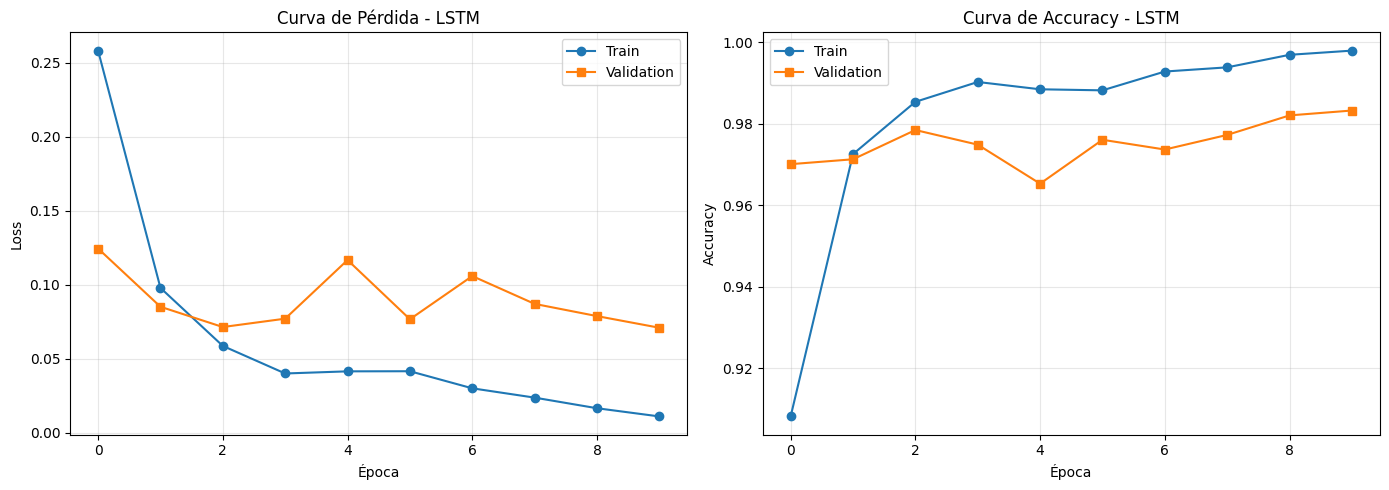

In [28]:
# Gráficas de entrenamiento LSTM
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(train_losses, label='Train', marker='o')
axes[0].plot(val_losses, label='Validation', marker='s')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Curva de Pérdida - LSTM')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train', marker='o')
axes[1].plot(val_accs, label='Validation', marker='s')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Curva de Accuracy - LSTM')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# Evaluación LSTM en test set
lstm_model.eval()
y_pred_lstm = []
y_pred_lstm_proba = []

with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device)
        outputs = lstm_model(sequences)
        predicted = (outputs > 0.5).float().cpu().numpy()
        y_pred_lstm.extend(predicted)
        y_pred_lstm_proba.extend(outputs.cpu().numpy())

y_pred_lstm = np.array(y_pred_lstm)
y_pred_lstm_proba = np.array(y_pred_lstm_proba)

print("\n" + "="*60)
print("RESULTADOS LSTM EN TEST SET")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lstm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lstm):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lstm):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_lstm):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_lstm, target_names=['No Spam', 'Spam']))


RESULTADOS LSTM EN TEST SET
Accuracy:  0.9797
Precision: 0.9279
Recall:    0.9196
F1-Score:  0.9238

Reporte de Clasificación:
              precision    recall  f1-score   support

     No Spam       0.99      0.99      0.99       724
        Spam       0.93      0.92      0.92       112

    accuracy                           0.98       836
   macro avg       0.96      0.95      0.96       836
weighted avg       0.98      0.98      0.98       836



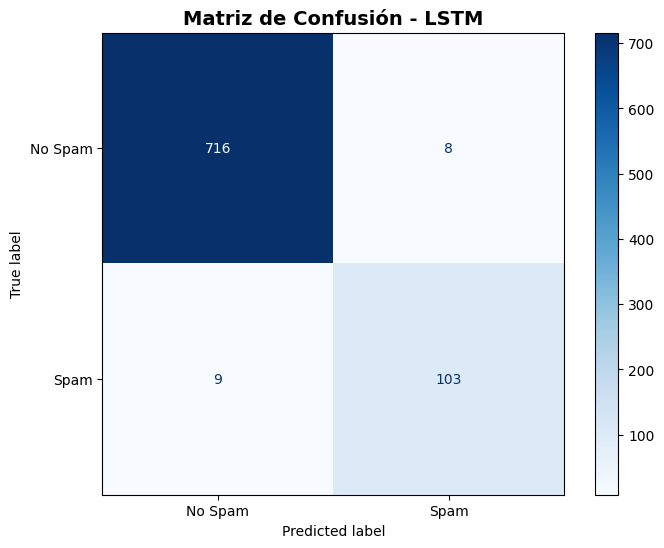

In [30]:
# Matriz de confusión LSTM
cm = confusion_matrix(y_test, y_pred_lstm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Spam', 'Spam'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title('Matriz de Confusión - LSTM', fontsize=14, fontweight='bold')
plt.savefig('lstm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.6 Modelo Avanzado #2: BERT (Transformers)

#### Arquitectura:
- **BERT base multilingual** (cased)
- Fine-tuning completo
- Capa de clasificación personalizada

#### Hiperparámetros Documentados:

In [31]:
# ==================== HIPERPARÁMETROS BERT ====================
BERT_CONFIG = {
    # Modelo
    'model_name': 'bert-base-multilingual-cased',  # Soporta español
    'max_length': 128,          # Longitud máxima de secuencia

    # Entrenamiento
    'batch_size': 16,           # Batch más pequeño (BERT es pesado)
    'learning_rate': 2e-5,      # LR típico para fine-tuning BERT
    'epochs': 3,                # Pocas épocas (BERT converge rápido)
    'warmup_steps': 100,        # Warmup para estabilidad
    'weight_decay': 0.01,       # Regularización L2
    'max_grad_norm': 1.0,       # Gradient clipping
}

print("Configuración del modelo BERT:")
for key, value in BERT_CONFIG.items():
    print(f"  {key}: {value}")

Configuración del modelo BERT:
  model_name: bert-base-multilingual-cased
  max_length: 128
  batch_size: 16
  learning_rate: 2e-05
  epochs: 3
  warmup_steps: 100
  weight_decay: 0.01
  max_grad_norm: 1.0


In [32]:
# Cargar tokenizador BERT
bert_tokenizer = BertTokenizer.from_pretrained(BERT_CONFIG['model_name'])

def tokenize_bert(texts, tokenizer, max_length):
    """Tokeniza textos con BERT tokenizer"""
    return tokenizer(
        texts.tolist(),
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )

# Tokenizar datos
train_encodings = tokenize_bert(X_train, bert_tokenizer, BERT_CONFIG['max_length'])
val_encodings = tokenize_bert(X_val, bert_tokenizer, BERT_CONFIG['max_length'])
test_encodings = tokenize_bert(X_test, bert_tokenizer, BERT_CONFIG['max_length'])

print(f"\nTokenización BERT completada")
print(f"Forma de input_ids: {train_encodings['input_ids'].shape}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]


Tokenización BERT completada
Forma de input_ids: torch.Size([3900, 128])


In [33]:
# Dataset BERT
class BERTDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.FloatTensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Crear datasets
bert_train_dataset = BERTDataset(train_encodings, y_train)
bert_val_dataset = BERTDataset(val_encodings, y_val)
bert_test_dataset = BERTDataset(test_encodings, y_test)

# DataLoaders
bert_train_loader = DataLoader(bert_train_dataset, batch_size=BERT_CONFIG['batch_size'], shuffle=True)
bert_val_loader = DataLoader(bert_val_dataset, batch_size=BERT_CONFIG['batch_size'])
bert_test_loader = DataLoader(bert_test_dataset, batch_size=BERT_CONFIG['batch_size'])

In [34]:
# Cargar modelo BERT
bert_model = BertForSequenceClassification.from_pretrained(
    BERT_CONFIG['model_name'],
    num_labels=1  # Clasificación binaria
).to(device)

# Optimizador con warmup
optimizer = AdamW(
    bert_model.parameters(),
    lr=BERT_CONFIG['learning_rate'],
    weight_decay=BERT_CONFIG['weight_decay']
)

# Scheduler con warmup
from transformers import get_linear_schedule_with_warmup

total_steps = len(bert_train_loader) * BERT_CONFIG['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=BERT_CONFIG['warmup_steps'],
    num_training_steps=total_steps
)

print(f"\nModelo BERT cargado")
print(f"Total de parámetros: {sum(p.numel() for p in bert_model.parameters()):,}")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Modelo BERT cargado
Total de parámetros: 177,854,209


In [35]:
# Entrenamiento BERT
def train_bert_epoch(model, loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in tqdm(loader, desc="Entrenando BERT"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device).unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        loss = nn.BCEWithLogitsLoss()(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), BERT_CONFIG['max_grad_norm'])
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        predicted = (torch.sigmoid(logits) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), correct / total

def evaluate_bert(model, loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).unsqueeze(1)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            loss = nn.BCEWithLogitsLoss()(logits, labels)

            total_loss += loss.item()
            predicted = (torch.sigmoid(logits) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(loader), correct / total

# Entrenamiento
print("\n" + "="*60)
print("ENTRENANDO MODELO BERT")
print("="*60)

bert_train_losses, bert_val_losses = [], []
bert_train_accs, bert_val_accs = [], []

for epoch in range(BERT_CONFIG['epochs']):
    train_loss, train_acc = train_bert_epoch(bert_model, bert_train_loader, optimizer, scheduler, device)
    val_loss, val_acc = evaluate_bert(bert_model, bert_val_loader, device)

    bert_train_losses.append(train_loss)
    bert_val_losses.append(val_loss)
    bert_train_accs.append(train_acc)
    bert_val_accs.append(val_acc)

    print(f"Época {epoch+1}/{BERT_CONFIG['epochs']}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print()


ENTRENANDO MODELO BERT


Entrenando BERT: 100%|██████████| 244/244 [01:32<00:00,  2.65it/s]


Época 1/3
  Train Loss: 0.1451, Train Acc: 0.9597
  Val Loss: 0.0715, Val Acc: 0.9868



Entrenando BERT: 100%|██████████| 244/244 [01:30<00:00,  2.69it/s]


Época 2/3
  Train Loss: 0.0354, Train Acc: 0.9921
  Val Loss: 0.0608, Val Acc: 0.9880



Entrenando BERT: 100%|██████████| 244/244 [01:30<00:00,  2.71it/s]


Época 3/3
  Train Loss: 0.0121, Train Acc: 0.9979
  Val Loss: 0.0528, Val Acc: 0.9892



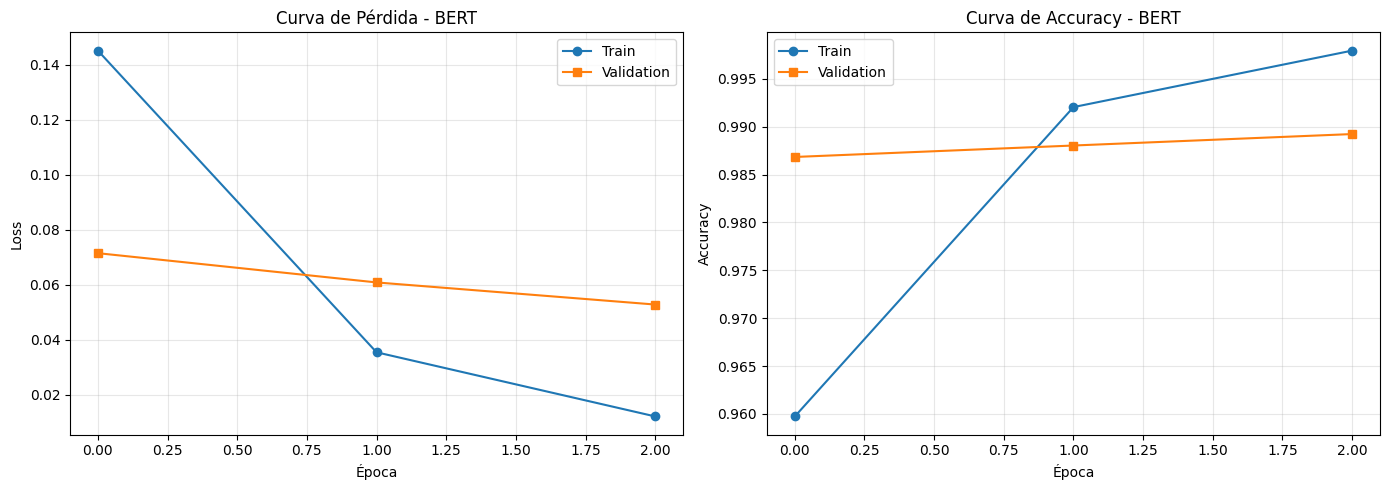

In [36]:
# Gráficas de entrenamiento BERT
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(bert_train_losses, label='Train', marker='o')
axes[0].plot(bert_val_losses, label='Validation', marker='s')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].set_title('Curva de Pérdida - BERT')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(bert_train_accs, label='Train', marker='o')
axes[1].plot(bert_val_accs, label='Validation', marker='s')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Curva de Accuracy - BERT')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('bert_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [37]:
# Evaluación BERT en test set
bert_model.eval()
y_pred_bert = []
y_pred_bert_proba = []

with torch.no_grad():
    for batch in bert_test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = bert_model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        predicted = (probs > 0.5).astype(float)

        y_pred_bert.extend(predicted.flatten())
        y_pred_bert_proba.extend(probs.flatten())

y_pred_bert = np.array(y_pred_bert)
y_pred_bert_proba = np.array(y_pred_bert_proba)

print("\n" + "="*60)
print("RESULTADOS BERT EN TEST SET")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_bert):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_bert):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_bert):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_bert):.4f}")
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_bert, target_names=['No Spam', 'Spam']))


RESULTADOS BERT EN TEST SET
Accuracy:  0.9940
Precision: 0.9820
Recall:    0.9732
F1-Score:  0.9776

Reporte de Clasificación:
              precision    recall  f1-score   support

     No Spam       1.00      1.00      1.00       724
        Spam       0.98      0.97      0.98       112

    accuracy                           0.99       836
   macro avg       0.99      0.99      0.99       836
weighted avg       0.99      0.99      0.99       836



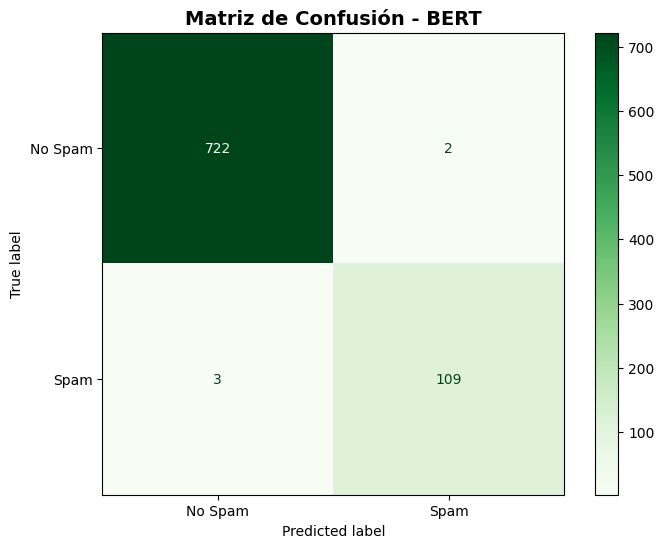

In [38]:
# Matriz de confusión BERT
cm = confusion_matrix(y_test, y_pred_bert)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Spam', 'Spam'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Greens', values_format='d')
plt.title('Matriz de Confusión - BERT', fontsize=14, fontweight='bold')
plt.savefig('bert_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
# 1. Limpiar X_test (el raw text utilizado por LSTM y BERT)
X_test_cleaned = [limpiar_texto(text) for text in X_test]

# 2. Vectorizar este X_test limpio usando el vectorizer ya entrenado
X_test_vec_consistent = vectorizer.transform(X_test_cleaned)

# 3. Generar nuevas predicciones para SVM y FFNN
y_pred_svm_consistent = svm.predict(X_test_vec_consistent)
y_pred_mlp_consistent = mlp.predict(X_test_vec_consistent)

print("Predicciones para SVM (tamaño):", y_pred_svm_consistent.shape)
print("Predicciones para FFNN (tamaño):", y_pred_mlp_consistent.shape)
print("y_test (tamaño):", y_test.shape)

Predicciones para SVM (tamaño): (836,)
Predicciones para FFNN (tamaño): (836,)
y_test (tamaño): (836,)


## 5. Evaluación (Evaluation)

### 5.1 Preparación de Datos para Comparación Consistente

In [42]:
# Tabla comparativa actualizada con predicciones consistentes
results = pd.DataFrame({
    'Modelo': ['SVM (Baseline)', 'FFNN (Baseline)', 'LSTM', 'BERT'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_svm_consistent),
        accuracy_score(y_test, y_pred_mlp_consistent),
        accuracy_score(y_test, y_pred_lstm),
        accuracy_score(y_test, y_pred_bert)
    ],
    'Precision': [
        precision_score(y_test, y_pred_svm_consistent),
        precision_score(y_test, y_pred_mlp_consistent),
        precision_score(y_test, y_pred_lstm),
        precision_score(y_test, y_pred_bert)
    ],
    'Recall': [
        recall_score(y_test, y_pred_svm_consistent),
        recall_score(y_test, y_pred_mlp_consistent),
        recall_score(y_test, y_pred_lstm),
        recall_score(y_test, y_pred_bert)
    ],
    'F1-Score': [
        f1_score(y_test, y_pred_svm_consistent),
        f1_score(y_test, y_pred_mlp_consistent),
        f1_score(y_test, y_pred_lstm),
        f1_score(y_test, y_pred_bert)
    ]
})

print("\n" + "="*80)
print("COMPARACIÓN DE TODOS LOS MODELOS (con test set unificado)")
print("="*80)
print(results.to_string(index=False))
print("="*80)


COMPARACIÓN DE TODOS LOS MODELOS (con test set unificado)
         Modelo  Accuracy  Precision   Recall  F1-Score
 SVM (Baseline)  0.988038   0.939655 0.973214  0.956140
FFNN (Baseline)  0.980861   0.893443 0.973214  0.931624
           LSTM  0.979665   0.927928 0.919643  0.923767
           BERT  0.994019   0.981982 0.973214  0.977578


### 5.2 Comparación de Todos los Modelos

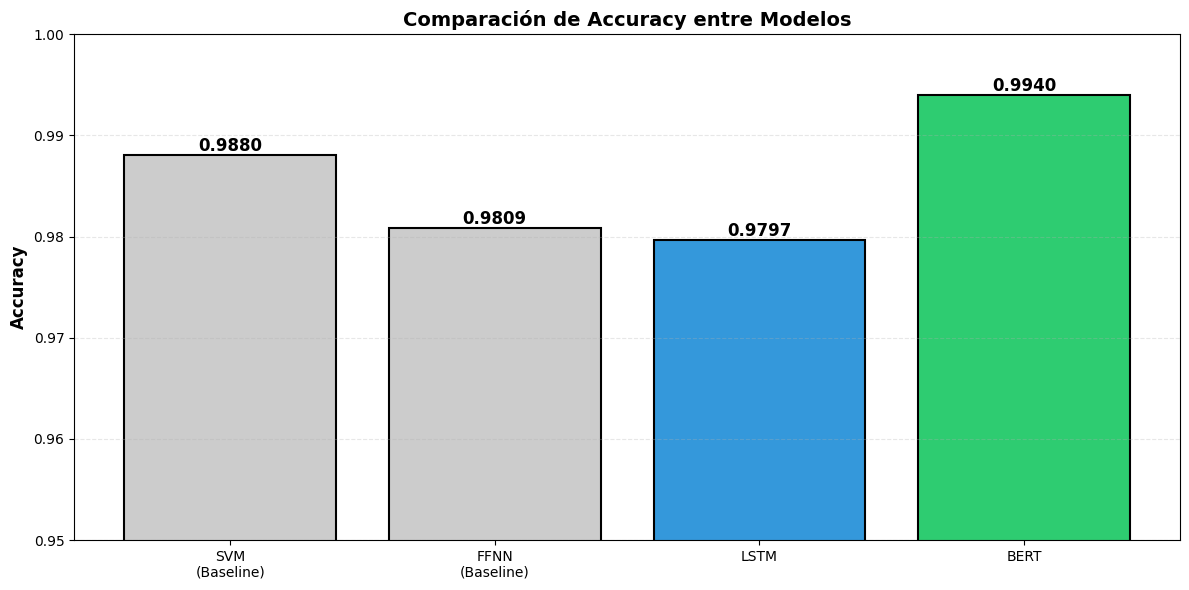

In [43]:
# Visualización comparativa
fig, ax = plt.subplots(figsize=(12, 6))

models = ['SVM\n(Baseline)', 'FFNN\n(Baseline)', 'LSTM', 'BERT']
accuracies = [
    accuracy_score(y_test, y_pred_svm_consistent),
    accuracy_score(y_test, y_pred_mlp_consistent),
    accuracy_score(y_test, y_pred_lstm),
    accuracy_score(y_test, y_pred_bert)
]

colors = ['#cccccc', '#cccccc', '#3498db', '#2ecc71']
bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=1.5)

# Añadir valores sobre las barras
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.4f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Accuracy entre Modelos', fontsize=14, fontweight='bold')
ax.set_ylim([0.95, 1.0])
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.3 Visualización Comparativa de Modelos

In [44]:
# Análisis de ejemplos donde los modelos fallan
print("\n" + "="*80)
print("ANÁLISIS DE ERRORES")
print("="*80)

# Falsos Positivos (clasificados como spam siendo no-spam)
fp_lstm = (y_pred_lstm == 1) & (y_test == 0)
fp_bert = (y_pred_bert == 1) & (y_test == 0)

# Falsos Negativos (clasificados como no-spam siendo spam)
fn_lstm = (y_pred_lstm == 0) & (y_test == 1)
fn_bert = (y_pred_bert == 0) & (y_test == 1)

print(f"\nLSTM:")
print(f"  Falsos Positivos: {fp_lstm.sum()}")
print(f"  Falsos Negativos: {fn_lstm.sum()}")

print(f"\nBERT:")
print(f"  Falsos Positivos: {fp_bert.sum()}")
print(f"  Falsos Negativos: {fn_bert.sum()}")

# Mostrar ejemplos de errores
print("\n" + "="*80)
print("EJEMPLOS DE FALSOS POSITIVOS (LSTM)")
print("="*80)
fp_indices = np.where(fp_lstm)[0][:5]  # Primeros 5
for i, idx in enumerate(fp_indices, 1):
    print(f"\n{i}. Texto: {X_test[idx][:200]}...")
    print(f"   Probabilidad: {y_pred_lstm_proba[idx]:.4f}")

print("\n" + "="*80)
print("EJEMPLOS DE FALSOS NEGATIVOS (LSTM)")
print("="*80)
fn_indices = np.where(fn_lstm)[0][:5]  # Primeros 5
for i, idx in enumerate(fn_indices, 1):
    print(f"\n{i}. Texto: {X_test[idx][:200]}...")
    print(f"   Probabilidad: {y_pred_lstm_proba[idx]:.4f}")


ANÁLISIS DE ERRORES

LSTM:
  Falsos Positivos: 8
  Falsos Negativos: 9

BERT:
  Falsos Positivos: 2
  Falsos Negativos: 3

EJEMPLOS DE FALSOS POSITIVOS (LSTM)

1. Texto: Chinatown tiene gachas, arroz en olla de barro, pastel de ñame, fideos de pescado... O comemos barato y luego vamos a un café a charlar o vamos a NYDC o algo así......
   Probabilidad: 0.9975

2. Texto: Hola, soy Yijue... Es sobre el libro de texto 3230, Introducción a los algoritmos, segunda edición... Lo estoy vendiendo por $50......
   Probabilidad: 0.9805

3. Texto: <#> se acerca rápidamente. Así que, te deseo un muy Feliz Año Nuevo, Feliz Sankranti, Feliz Día de la República, Feliz Día de San Valentín, Feliz Shivratri, Feliz Ugadi, Feliz Día de los Inocentes, Fe...
   Probabilidad: 0.9970

4. Texto: Conocemos el TAJ MAHAL como un símbolo del amor. Pero los otros hechos menos conocidos son: 1. Mumtaz fue la cuarta esposa de Shahjahan, de sus 7 esposas. 2. Shahjahan mató al esposo de Mumtaz para ca...
   Probabilid

### 5.4 Análisis de Errores y Clasificaciones Incorrectas

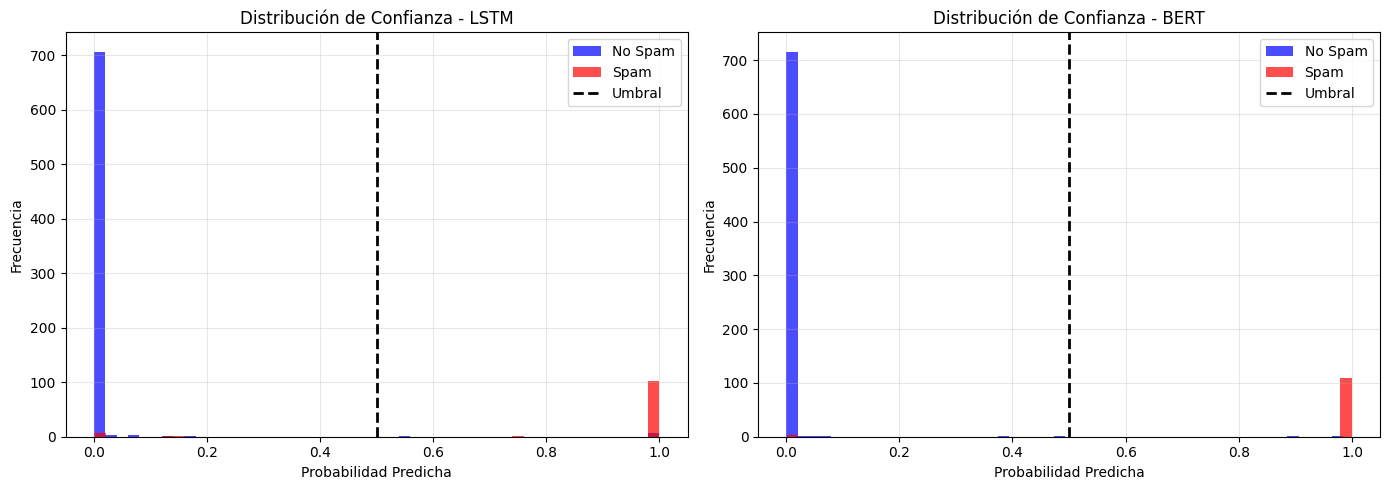

In [45]:
# Análisis de confianza de predicciones
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSTM
axes[0].hist(y_pred_lstm_proba[y_test == 0], bins=50, alpha=0.7, label='No Spam', color='blue')
axes[0].hist(y_pred_lstm_proba[y_test == 1], bins=50, alpha=0.7, label='Spam', color='red')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral')
axes[0].set_xlabel('Probabilidad Predicha')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de Confianza - LSTM')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# BERT
axes[1].hist(y_pred_bert_proba[y_test == 0], bins=50, alpha=0.7, label='No Spam', color='blue')
axes[1].hist(y_pred_bert_proba[y_test == 1], bins=50, alpha=0.7, label='Spam', color='red')
axes[1].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral')
axes[1].set_xlabel('Probabilidad Predicha')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución de Confianza - BERT')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### 5.5 Análisis de Confianza en las Predicciones

In [46]:
import random

# Ejemplo simple de augmentación: Random Deletion
def random_deletion(text, p=0.1):
    """Elimina palabras aleatoriamente con probabilidad p"""
    words = text.split()
    if len(words) == 1:
        return text

    new_words = []
    for word in words:
        if random.random() > p:
            new_words.append(word)

    if len(new_words) == 0:
        return random.choice(words)

    return ' '.join(new_words)

# Ejemplo simple de augmentación: Random Swap
def random_swap(text, n=1):
    """Intercambia n pares de palabras aleatoriamente"""
    words = text.split()
    if len(words) < 2:
        return text

    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(new_words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]

    return ' '.join(new_words)

# Demostración
ejemplo = "Gana dinero rápido con esta oferta increíble"
print("Texto original:")
print(f"  {ejemplo}")
print("\nAugmentación con Random Deletion:")
for i in range(3):
    print(f"  {random_deletion(ejemplo, p=0.2)}")
print("\nAugmentación con Random Swap:")
for i in range(3):
    print(f"  {random_swap(ejemplo, n=2)}")

Texto original:
  Gana dinero rápido con esta oferta increíble

Augmentación con Random Deletion:
  Gana dinero rápido con oferta increíble
  Gana dinero rápido con oferta
  dinero rápido con esta oferta increíble

Augmentación con Random Swap:
  Gana increíble con rápido esta oferta dinero
  dinero Gana rápido con increíble oferta esta
  dinero Gana rápido con oferta esta increíble


### 5.6 Técnicas de Mejora: Data Augmentation

In [47]:
# Ejemplo de Ensemble: Promedio de predicciones
y_pred_ensemble = (y_pred_lstm_proba + y_pred_bert_proba) / 2
y_pred_ensemble_binary = (y_pred_ensemble > 0.5).astype(int)

print("\n" + "="*60)
print("RESULTADOS ENSEMBLE (LSTM + BERT)")
print("="*60)
print(f"Accuracy:  {accuracy_score(y_test, y_pred_ensemble_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_ensemble_binary):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_ensemble_binary):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_ensemble_binary):.4f}")


RESULTADOS ENSEMBLE (LSTM + BERT)
Accuracy:  0.9928
Precision: 0.9732
Recall:    0.9732
F1-Score:  0.9732


### 5.7 Ensemble de Modelos (LSTM + BERT)

In [48]:
# Crear versiones perturbadas de ejemplos de test
def test_robustness(model, text, perturbation_fn, n_trials=5):
    """Prueba robustez aplicando perturbaciones"""
    # Predicción original
    if isinstance(model, nn.Module):
        model.eval()

    predictions = []

    for _ in range(n_trials):
        perturbed = perturbation_fn(text)
        # Aquí necesitarías implementar la predicción según el modelo
        # Este es un ejemplo conceptual
        predictions.append(perturbed)

    return predictions

# Ejemplo conceptual
ejemplo_spam = X_test[y_test == 1][0]
print("Ejemplo de spam original:")
print(f"  {ejemplo_spam}")
print("\nVersiones perturbadas (Random Deletion):")
for i in range(5):
    print(f"  {i+1}. {random_deletion(ejemplo_spam, p=0.15)}")

Ejemplo de spam original:
  Estimado 0776xxxxxxx, has sido invitado a XCHAT. ¡Este es nuestro último intento de contactarte! Envía CHAT al 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18 años.

Versiones perturbadas (Random Deletion):
  1. Estimado 0776xxxxxxx, has sido invitado a XCHAT. ¡Este es nuestro último intento de contactarte! Envía CHAT 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18
  2. Estimado 0776xxxxxxx, has sido a XCHAT. ¡Este es último intento de Envía al 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 18
  3. Estimado has sido invitado a XCHAT. ¡Este es nuestro intento de contactarte! CHAT al 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN años.
  4. 0776xxxxxxx, has sido invitado a XCHAT. es nuestro último intento de contactarte! Envía al 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN años.
  5. Estimado 0776xxxxxxx, has invitado XCHAT. ¡Este es nuestro último intento contactarte! Envía CHAT al 86688 150p/MsgrcvdHG/Suite342/2Lands/Row/W1J6HL LDN 

### 5.8 Pruebas de Robustez

## 6. Despliegue (Deployment)

### 6.1 Ejemplos de Predicción en Nuevos Mensajes

In [ ]:
import numpy as np

# Frases de ejemplo para probar
example_phrases = [
    "Felicitaciones! Has ganado un premio de 1000 euros. Reclama en link.ly/premio",
    "Hola, ¿cómo estás? Quería saber si tenías tiempo para tomar un café mañana.",
    "URGENTE: Tu cuenta bancaria ha sido comprometida. Confirma tus datos en www.banco.com/seguridad",
    "No olvides nuestra reunión el viernes a las 10 AM en la sala principal.",
    "Tu número ha sido seleccionado para un sorteo exclusivo. Llama al 902123456 ahora mismo.",
    "Me gustaria que me dieras feedback sobre el proyecto que te envié ayer."
]

def predict_with_lstm(text, model, word2idx, max_length, device):
    model.eval()
    sequence = text_to_sequence(text, word2idx, max_length)
    input_tensor = torch.LongTensor(sequence).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        prediction = (output > 0.5).item()
    return "Spam" if prediction == 1 else "No Spam", output.item()

def predict_with_bert(text, model, tokenizer, max_length, device):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probability = torch.sigmoid(logits).item()
        prediction = (probability > 0.5)
    return "Spam" if prediction == 1 else "No Spam", probability

print("\n" + "="*80)
print("PREDICCIONES PARA NUEVAS FRASES")
print("="*80)

for i, phrase in enumerate(example_phrases):
    print(f"\n--- Frase {i+1} ---")
    print(f"Texto: {phrase}")

    # Predicción LSTM
    lstm_pred_label, lstm_pred_proba = predict_with_lstm(phrase, lstm_model, word2idx, LSTM_CONFIG['max_length'], device)
    print(f"LSTM -> Clasificación: {lstm_pred_label} (Prob: {lstm_pred_proba:.4f})")

    # Predicción BERT
    bert_pred_label, bert_pred_proba = predict_with_bert(phrase, bert_model, bert_tokenizer, BERT_CONFIG['max_length'], device)
    print(f"BERT -> Clasificación: {bert_pred_label} (Prob: {bert_pred_proba:.4f})")



PREDICCIONES PARA NUEVAS FRASES

--- Frase 1 ---
Texto: Felicitaciones! Has ganado un premio de 1000 euros. Reclama en link.ly/premio
LSTM -> Clasificación: Spam (Prob: 0.9973)
BERT -> Clasificación: Spam (Prob: 0.9986)

--- Frase 2 ---
Texto: Hola, ¿cómo estás? Quería saber si tenías tiempo para tomar un café mañana.
LSTM -> Clasificación: No Spam (Prob: 0.0031)
BERT -> Clasificación: No Spam (Prob: 0.0011)

--- Frase 3 ---
Texto: URGENTE: Tu cuenta bancaria ha sido comprometida. Confirma tus datos en www.banco.com/seguridad
LSTM -> Clasificación: Spam (Prob: 0.9981)
BERT -> Clasificación: Spam (Prob: 0.9979)

--- Frase 4 ---
Texto: No olvides nuestra reunión el viernes a las 10 AM en la sala principal.
LSTM -> Clasificación: No Spam (Prob: 0.0005)
BERT -> Clasificación: No Spam (Prob: 0.0016)

--- Frase 5 ---
Texto: Tu número ha sido seleccionado para un sorteo exclusivo. Llama al 902123456 ahora mismo.
LSTM -> Clasificación: Spam (Prob: 0.9995)
BERT -> Clasificación: Spam (Prob: 0.